In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import nglview as nv

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms, pca, diffusionmap, distances
from MDAnalysis.analysis.hydrogenbonds import hbond_analysis

/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
log_df = pd.read_csv("result/log.txt",sep="\t")

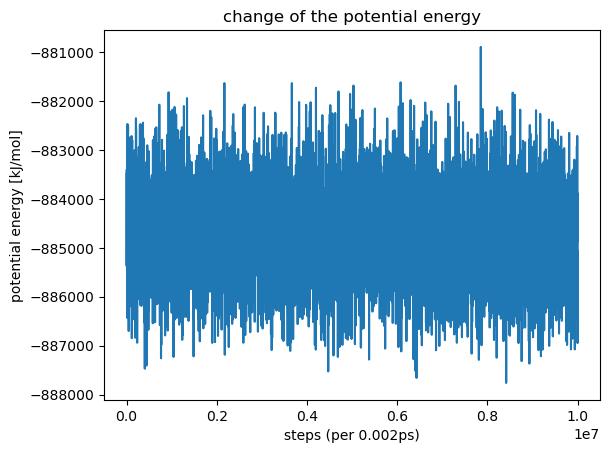

In [3]:
x = log_df["Step"]
y = log_df["Potential Energy (kJ/mole)"]
plt.plot(x,y)
plt.title("change of the potential energy")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("potential energy [kJ/mol]")
plt.show()

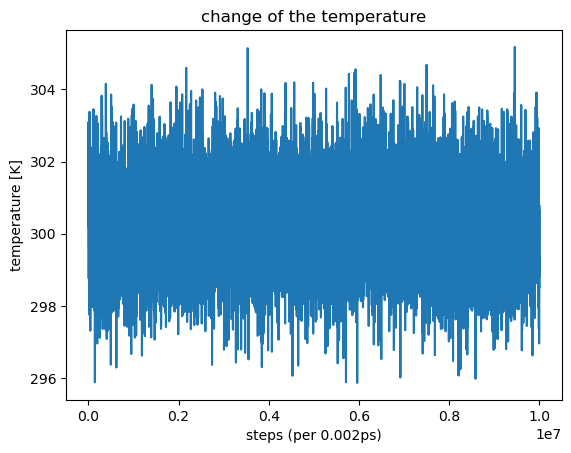

In [4]:
x = log_df["Step"]
y2 = log_df["Temperature (K)"]
plt.plot(x, y2)
plt.title("change of the temperature")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("temperature [K]")
plt.show()

---

In [5]:
md_universe = mda.Universe("data/2xjx_SMIRNOFF_processed.pdb","result/trajectory.dcd")
alignment = align.AlignTraj(mobile=md_universe,reference=md_universe,select="name CA",in_memory=True)
alignment.run()

/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [6]:
view = nv.show_mdanalysis(md_universe)
view

NGLWidget(max_frame=999)

In [7]:
md_universe.trajectory[500]
RMSD_analysis = rms.RMSD(md_universe,reference=md_universe,select="backbone",
                         groupselections=["protein","resname UNK"],ref_frame=500)
RMSD_analysis.run()

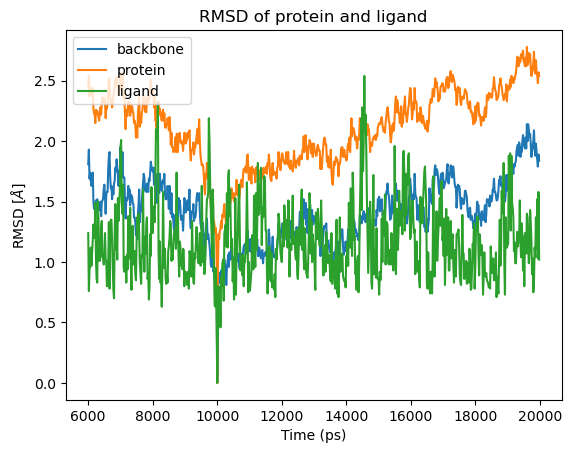

In [8]:
# backbone基準としたRMSDで描画
# 前半でproteinの位置が飛んでたので途中を基準とする
column_names = ['frame', 'time(ps)', 'backbone', 'protein', 'ligand']
rmsd_df = pd.DataFrame(np.round(RMSD_analysis.results.rmsd, 2), columns = column_names).iloc[300:]

plt.plot(rmsd_df['time(ps)'], rmsd_df['backbone'], label="backbone")
plt.plot(rmsd_df['time(ps)'], rmsd_df['protein'], label="protein")
plt.plot(rmsd_df['time(ps)'], rmsd_df['ligand'], label="ligand")
plt.legend(loc="upper left")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD [$\AA$]")
plt.title("RMSD of protein and ligand")

plt.show()

In [34]:
pairwase_protein = diffusionmap.DistanceMatrix(md_universe, select = "protein")
pairwase_protein.run()
dist_matrix_protein = pairwase_protein.results.dist_matrix[200:,200:]

pairwase_ligand = diffusionmap.DistanceMatrix(md_universe, select = "resname UNK")
pairwase_ligand.run()
dist_matrix_ligand = pairwase_ligand.results.dist_matrix[200:,200:]

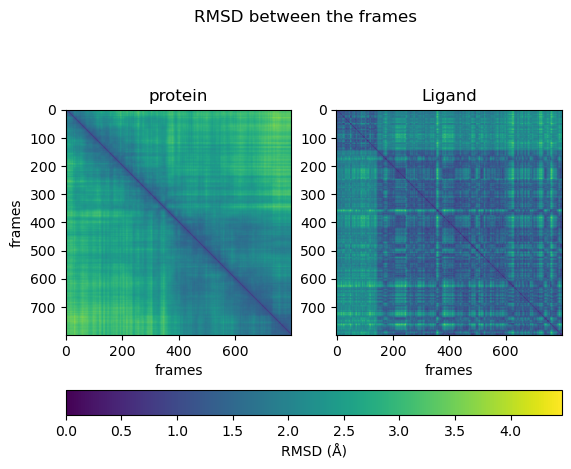

In [35]:
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)")

---

In [12]:
import prolif as plf
from prolif.plotting.network import LigNetwork
from prolif.plotting.complex3d import Complex3D
from prolif.plotting.barcode import Barcode

In [13]:
lig = md_universe.atoms.select_atoms("resname UNK")
prot = md_universe.atoms.select_atoms("protein")
fp = plf.Fingerprint()
fp.run(md_universe.trajectory[::10],lig,prot)

  0%|          | 0/100 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7fec24fec990>

In [14]:
df_fp = fp.to_dataframe()
lmol = plf.Molecule.from_mda(lig)
net = LigNetwork.from_fingerprint(fp,lmol,display_all=True,threshold=0.1)
net.display()

<Axes: xlabel='Frame'>

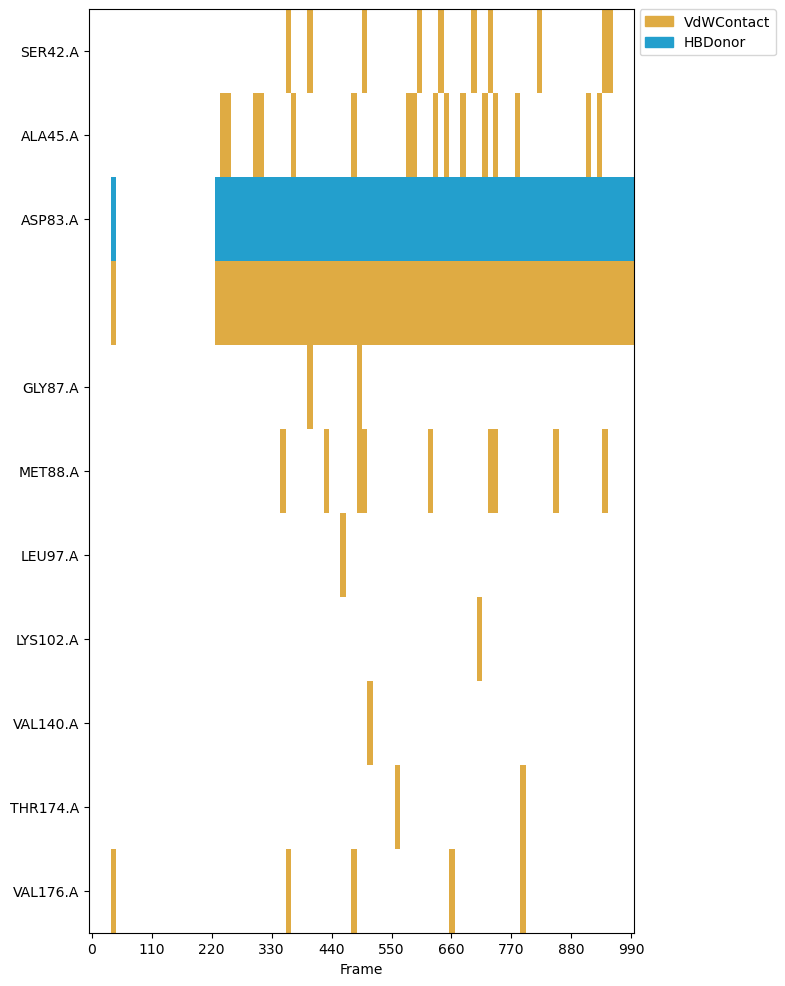

In [15]:
barcode = Barcode(df_fp)
barcode.display()

In [55]:
md_universe.trajectory[500]
asp83 = md_universe.select_atoms("resid 83 and resname ASP and name N")
unk_o = md_universe.select_atoms("resname UNK and name O1")
dist = distances.dist(asp83,unk_o)
print(dist)

[[83.        ]
 [ 1.        ]
 [ 8.99164652]]


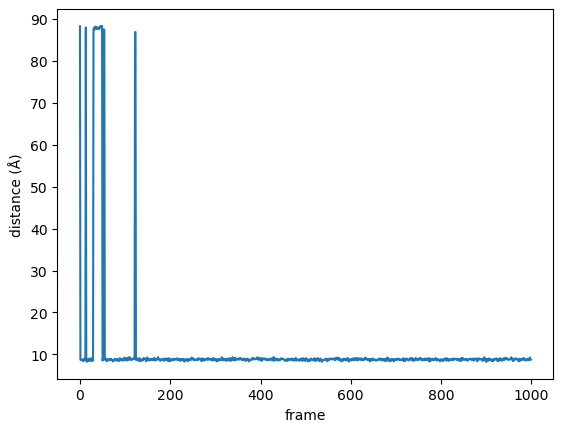

In [56]:
distlist = []
for _ in md_universe.trajectory:
    dist_t = distances.dist(asp83,unk_o)[2][0]
    distlist.append(dist_t)
plt.plot(distlist)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.show()

---

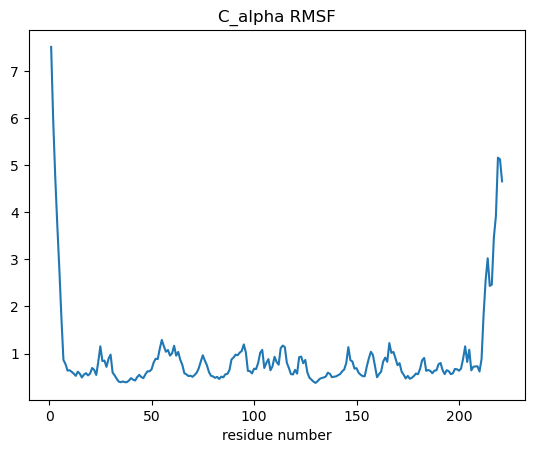

In [16]:
C_alphas = md_universe.select_atoms("name CA")
RMSF_analysis = rms.RMSF(C_alphas)
RMSF_analysis.run()

residue_numbers = C_alphas.resnums
plt.plot(residue_numbers, RMSF_analysis.results.rmsf)
plt.title("C_alpha RMSF")
plt.xlabel("residue number")
plt.show()

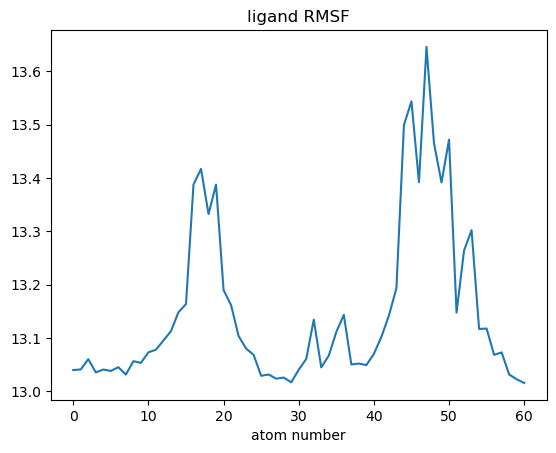

In [63]:
ligands = md_universe.select_atoms("resname UNK")
RMSF_analysis = rms.RMSF(ligands)
RMSF_analysis.run()

atom_numbers = ligands.n_atoms
plt.plot(range(atom_numbers), RMSF_analysis.results.rmsf)
plt.title("ligand RMSF")
plt.xlabel("atom number")
plt.show()

ligandが飛んでるので値が信頼のないものになっている

In [17]:
coords = []
for i in range(1000):
    md_universe.trajectory[i]
    coords.append(md_universe.select_atoms("name CA").positions)
coords = np.array(coords)
# [50, 327, 3]
m = np.mean(coords,axis=0) # <Ri> [327, 3]
dr = coords - m # Δri

In [20]:
cij = []
for i in tqdm(range(dr.shape[1])):
    temp = []
    for j in range(dr.shape[1]):
        dri = dr[:,i]
        drj = dr[:,j]
        upper = np.mean([np.dot(v,w) for v,w in zip(dri,drj)])
        dri2_m = np.mean([np.linalg.norm(v)**2 for v in dri],axis=0)
        drj2_m = np.mean([np.linalg.norm(v)**2 for v in drj],axis=0)
        lower = np.sqrt(dri2_m * drj2_m)
        temp.append(upper / lower)
    cij.append(temp)

  0%|          | 0/221 [00:00<?, ?it/s]

<Axes: >

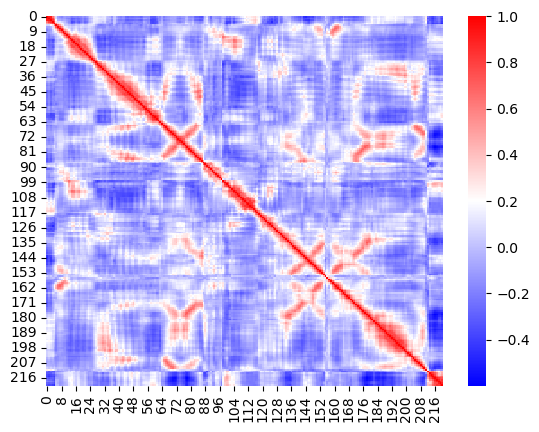

In [21]:
sns.heatmap(cij,cmap="bwr")

---

In [74]:
Ca_pca = pca.PCA(md_universe,select="name CA")
Ca_pca.run()

In [75]:
transformed = Ca_pca.transform(md_universe.select_atoms("name CA"), n_components=3)
print("shape of the array : ", transformed.shape)

shape of the array :  (1000, 3)


In [76]:
frame_time = md_universe.trajectory.dt
df = pd.DataFrame(transformed, columns=['PC1', 'PC2', 'PC3'])
df['Time (ps)'] = df.index * frame_time
df.head()

,PC1,PC2,PC3,Time (ps)
0,-28.700141,3.178802,-8.795976,0.0
1,-30.382874,5.229900,-9.419235,20.0
2,-29.312237,6.312110,-10.148955,40.0
3,-28.820377,4.641440,-9.362409,60.0
4,-29.728086,1.701006,-9.525096,80.0


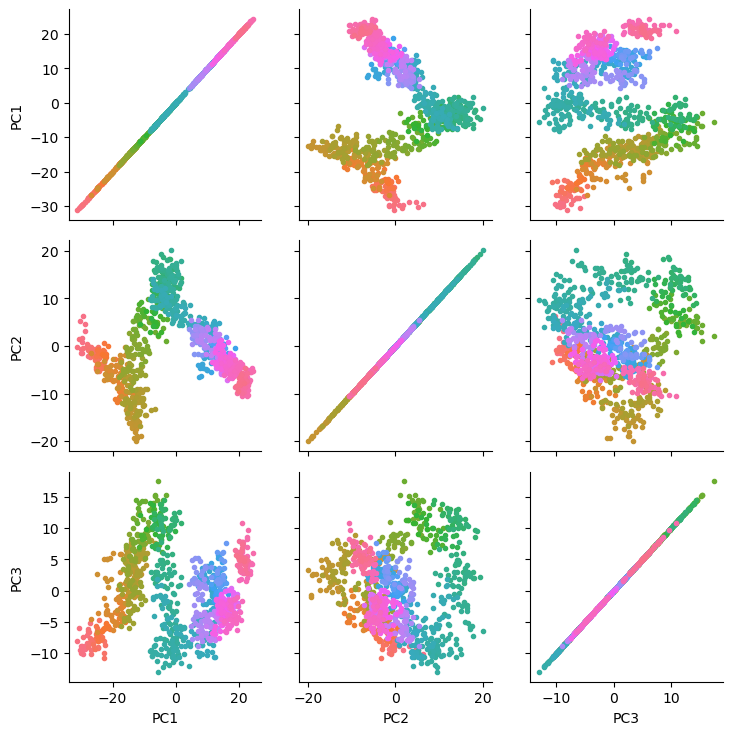

In [77]:
pair_grid_plot = sns.PairGrid(df, hue='Time (ps)')
pair_grid_plot.map(plt.scatter, marker='.')

In [70]:
proj_univ = []
for i in range(3):
    pc = Ca_pca.results.p_components[:,i]
    weight = transformed[:,i]
    mean_coord = Ca_pca.mean
    projected = np.outer(weight,pc) + mean_coord.flatten()
    coordinates = projected.reshape(len(weight),-1,3)
    proj = mda.Merge(md_universe.select_atoms("name CA"))
    proj.load_new(coordinates,order="fac")
    proj_univ.append(proj)

In [71]:
view = nv.show_mdanalysis(proj_univ[0].atoms)
view

NGLWidget(max_frame=999)

In [78]:
view = nv.show_mdanalysis(proj_univ[1].atoms)
view

NGLWidget(max_frame=999)

In [79]:
Ca_pca = pca.PCA(md_universe,select="resname UNK")
Ca_pca.run()
transformed = Ca_pca.transform(md_universe.select_atoms("resname UNK"), n_components=3)
proj_univ_l = []
for i in range(3):
    pc = Ca_pca.results.p_components[:,i]
    weight = transformed[:,i]
    mean_coord = Ca_pca.mean
    projected = np.outer(weight,pc) + mean_coord.flatten()
    coordinates = projected.reshape(len(weight),-1,3)
    proj = mda.Merge(md_universe.select_atoms("resname UNK"))
    proj.load_new(coordinates,order="fac")
    proj_univ_l.append(proj)

In [85]:
view = nv.show_mdanalysis(proj_univ_l[2].atoms)
view

NGLWidget(max_frame=999)